<a href="https://colab.research.google.com/github/barauna-lo/Neurocomputing/blob/main/Project_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png align=”middle”>](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/barauna-lo/Deep-Learning/blob/main/LogoCAP.png?raw=true" width = 450 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


# Project 01 - Multi-layer Perceptron (MLP)

* [Luan Orion Baraúna](https://www.linkedin.com/in/luan-orion-barauna/)


## PROJETO 1 – REDE MLP

1. Selecionar dois datasets (não triviais)

  * Um dataset para classificação
  * Um dataset para regressão
  * Separar em treino/validação/teste

2. Treinar modelos MLP para os dois problemas

3. Considerar:

  * Diferentes topologias (>=5 topologias, variar número de
camadas

  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  
  * Avaliar o impacto do uso do Momentum

  * Avaliar o impacto do uso da regularização (i.e. L2)
  
  * [EXTRA] Avaliar o impacto do Dropout

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados

In [48]:
#Importing Librarys 📚
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import time # for time mesurment
import tensorflow as tf
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from IPython.display import HTML

print(tf.__version__)

2.8.2


# Regression

The regression problem consists of searching for a mathematical expression whose function f(x) can describe a given set of data. This technique is used when you have the points of a certain measure but not the law that describes that phenomenon.

In general, any curve can be associated with a set of nth-order polynomials or a set of straight lines. For the case of a neural network, the non-linearity of how the weights influence a given function is difficult to describe, however it has the generalization capacity similar to linear regression.

Below we can see an example of points being fitted by a curve according to the training epochs.

<img src="https://www.cs.toronto.edu/~frossard/post/multiple_linear_regression/multiple_lreg.gif">

font: https://www.cs.toronto.edu/~frossard/post/multiple_linear_regression/


Here I will present 5 topologies of a Multilayer Perceptron, gradually increasing the number of neurons and number of layers. For each topology I will change the hyperparameters of "momentun", "regularization" and "droup out. Having a total of 6 variations.

* No Regularization, no Dropoutr, no Momentun.
* 0.2 Regularization, no Dropout, no Momentun.
* No Regularization, 0.2 Dropout, no Momentun.
* No Regularization, no Dropoutr, 0.2 Momentun.
* 0.2 Regularization, without Dropoutr, 0.2 Momentun.
* 0.2 Regularization, 0.2 Dropoutr, 0.2 Momentun.

The activation functions are the same in all topologies with the exception of topology 5 which follows the same structure as topology 4.

In this way, we can observe how the regularization is sensitive to these hyperparameters.

## Dataset

This dataset refers to the Power Spectrum Desity Function (PSD) of the two-point correlation function of the Cosmic Background Radiation and is of great importance for the determination of the cosmological parameters. This data carry the information of how matter are splitet in the larg scale universe. 

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/Sound%20waves%20in%20space%20Baryon%20Acoustic%20Oscillations.gif?raw=true"> 

This data set can be found at 
http://pla.esac.esa.int/pla/#cosmology

font: https://youtu.be/jpXuYc-wzk4



In [50]:
!wget "http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt"

--2022-07-13 22:45:43--  http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:80... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/x-binary]
Saving to: ‘product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt.1’

product-action?COSM     [    <=>             ] 166.55K   221KB/s    in 0.8s    

2022-07-13 22:45:45 (221 KB/s) - ‘product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt.1’ saved [170547]



In [51]:
df = pd.read_fwf('product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt')
df.columns = ["id","l", "Dl", "+dDl", "-dDl"]
df.drop('id', axis=1, inplace=True)

In [52]:
#Normalize data
df.l =  (df.l - df.l.mean()) / df.l.std()
df.Dl =  (df.Dl - df.Dl.mean()) / df.Dl.std()
df['+dDl'] =  (df['+dDl'] - df['+dDl'].mean()) / df['+dDl'].std()
df['+dDl'] =  (df['-dDl'] - df['-dDl'].mean()) / df['-dDl'].std()

$$ D_l = \frac{l(l+1)Cl}{(2\pi)} $$

[]

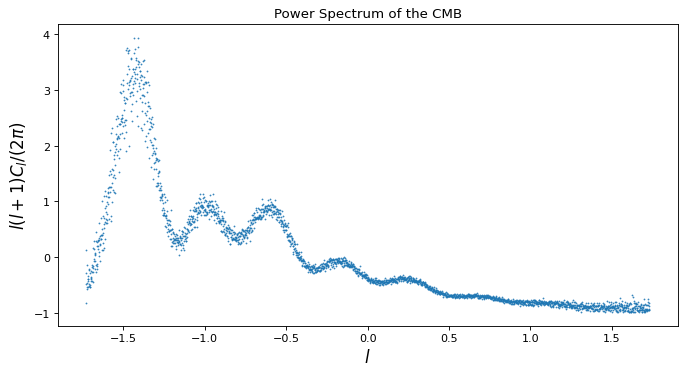

In [53]:
#from IPython.core.pylabtools import figsize
figure(figsize=(10,5),dpi=80)
plt.scatter(df.l,df.Dl,s=0.3)
#plt.errorbar(l, Dl, df.min_error, df.max_error, fmt='r^')
#plt.xscale('log')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
plt.title("Power Spectrum of the CMB")
plt.plot()


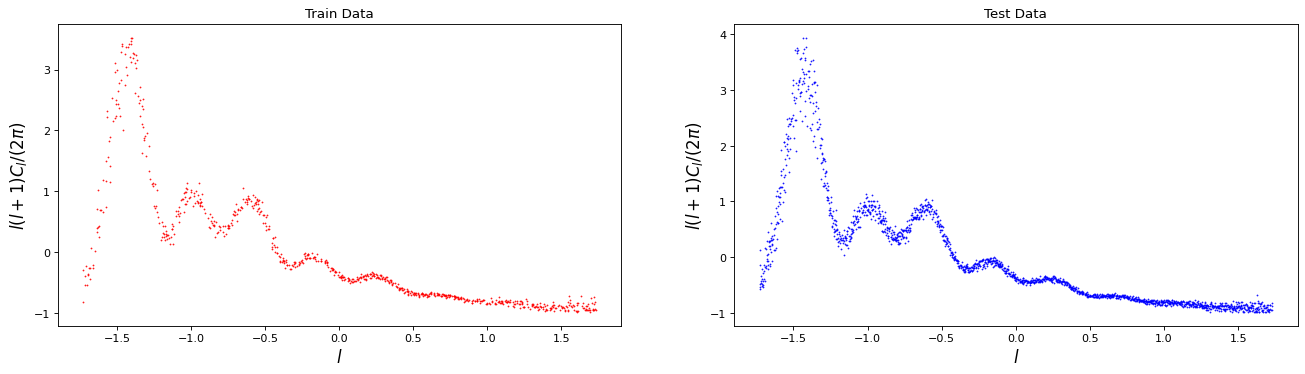

In [54]:
# Spliting in traing and Validation 
x_train, x_test, y_train, y_test = train_test_split(df.l, df.Dl, test_size=0.7)
# print(len(x_train))
# print(len(x_test))
figure(figsize=(20,5),dpi=80)

plt.subplot(1,2,1)
plt.scatter(x_train, y_train, color='red',s=0.3)
plt.title('Train Data')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
#plt.xscale('log')

plt.subplot(1,2,2)
plt.scatter(x_test, y_test, color='blue',s=0.3)
plt.title('Test Data')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
#plt.xscale('log')
plt.show()


## Comun parametes

In [55]:
#Paramentes
adam = tf.keras.optimizers.Adam()

## Topology 1

To attempt to build a network capable of finding a regression law for these problems, we will generate 5 different network topologies. The first will be the simple and classic case of a perceptron and the second will increase the number of layers and the number of neurons.

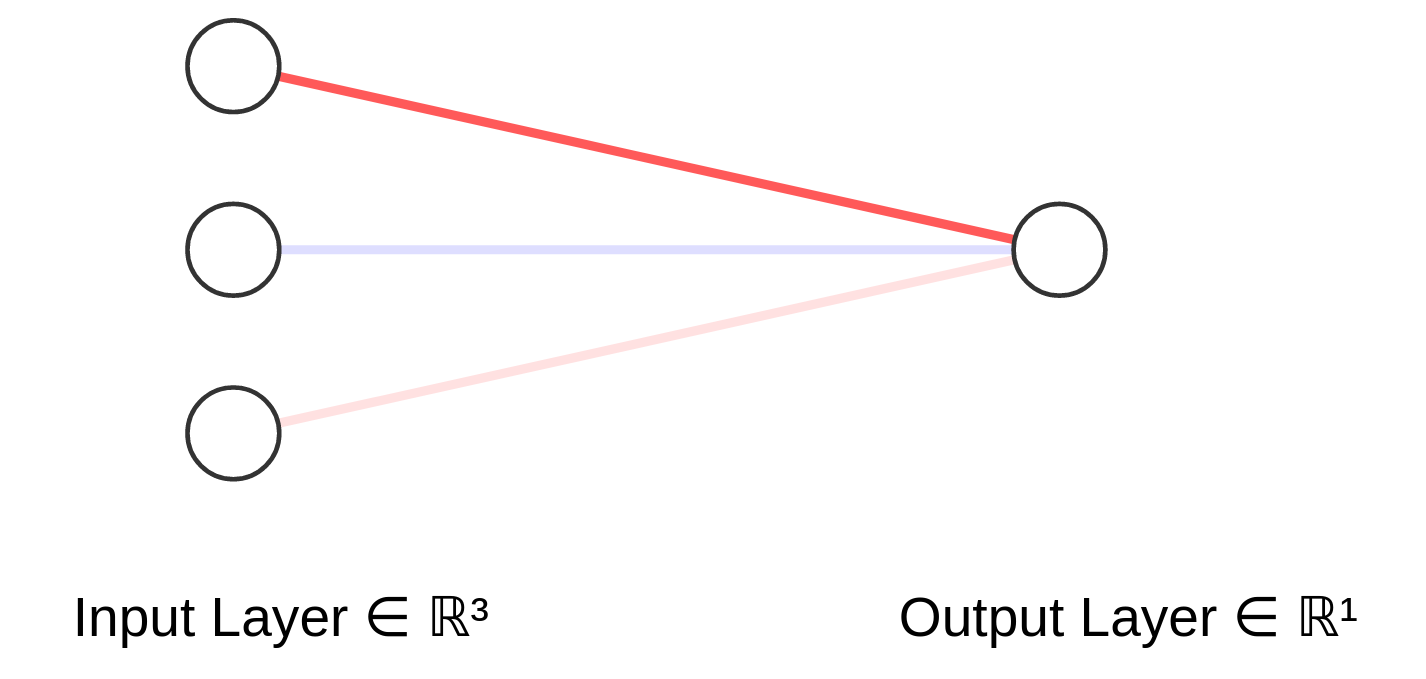

### Models for Topology 1

In [56]:
model_1 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_1.append(keras.Sequential())
  model_1[i].add(keras.layers.Dense(units=3,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_1[i].add(Dropout(dropo[i]))
  model_1[i].add(keras.layers.Dense(units=1,kernel_regularizer=l2(regul[i]), activation="linear"))
  model_1[i].compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

### Treining Topology 1

In [57]:
#O que é isso?
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___1 = []
endti___1 = []
history_1 = []
for i in range(len(regul)):
  start___1.append(time.time())
  history_1.append(
    model_1[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___1.append(time.time())

A saída de streaming foi truncada nas últimas 5000 linhas.
61/61 [==============================] - 0s 3ms/step - loss: 0.3136 - mean_absolute_error: 0.2940 - val_loss: 0.1979 - val_mean_absolute_error: 0.2240
Epoch 502/1000
61/61 [==============================] - 0s 3ms/step - loss: 0.3132 - mean_absolute_error: 0.2928 - val_loss: 0.1952 - val_mean_absolute_error: 0.2201
Epoch 503/1000
61/61 [==============================] - 0s 3ms/step - loss: 0.3134 - mean_absolute_error: 0.2934 - val_loss: 0.1960 - val_mean_absolute_error: 0.2212
Epoch 504/1000
61/61 [==============================] - 0s 3ms/step - loss: 0.3133 - mean_absolute_error: 0.2932 - val_loss: 0.1954 - val_mean_absolute_error: 0.2205
Epoch 505/1000
61/61 [==============================] - 0s 3ms/step - loss: 0.3132 - mean_absolute_error: 0.2924 - val_loss: 0.1953 - val_mean_absolute_error: 0.2202
Epoch 506/1000
61/61 [==============================] - 0s 4ms/step - loss: 0.3134 - mean_absolute_error: 0.2933 - val_loss: 0

### Results Topology 1

In [58]:
#Time Running Out
for i in range(len(start___1)):
  print(round((    endti___1[i]- start___1[i])/60,5),'minuts')
print(round((      endti___1[-1]-start___1[0])/60,5),'minuts TOTAL')

3.37324 minuts
4.37355 minuts
4.38267 minuts
3.7391 minuts
4.37669 minuts
4.3769 minuts
24.62216 minuts TOTAL


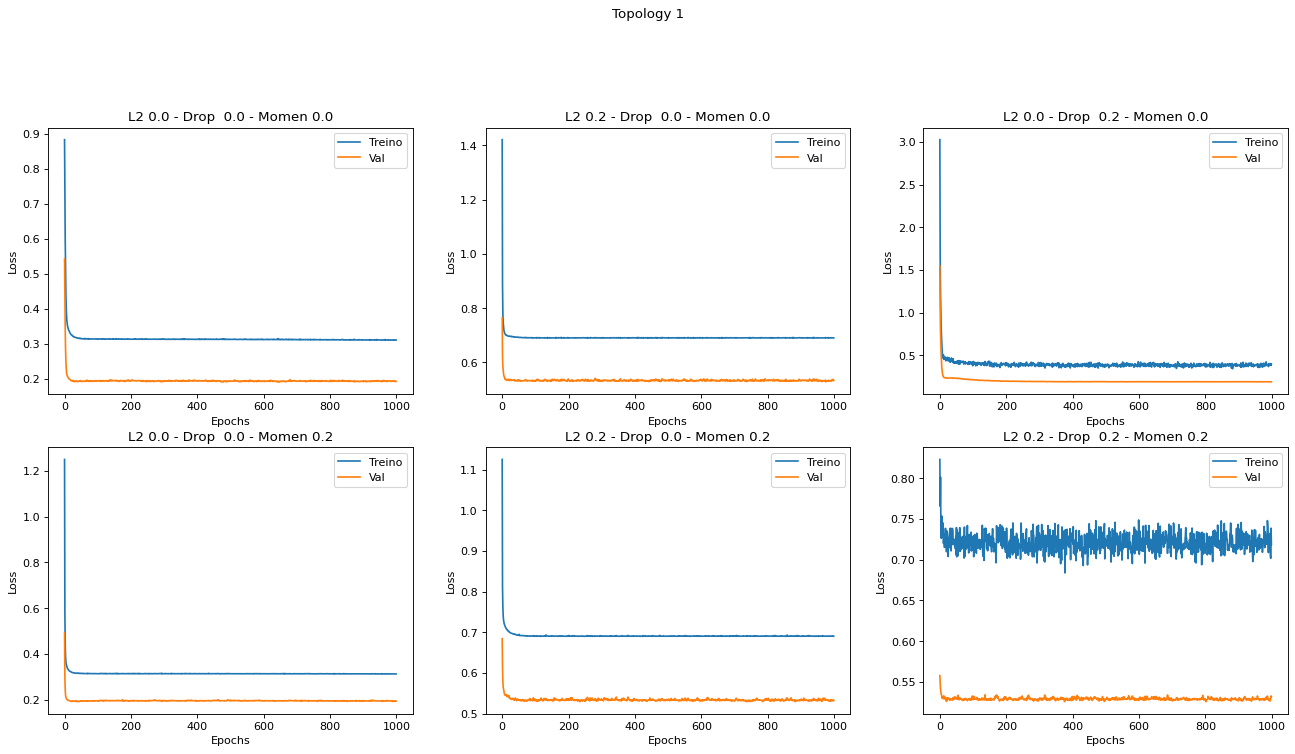

In [59]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("Topology 1")
for i in range(len(model_1)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(history_1[i].history['loss'], label="Treino")
  plt.plot(history_1[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.legend()

### Avaliation Topology 1

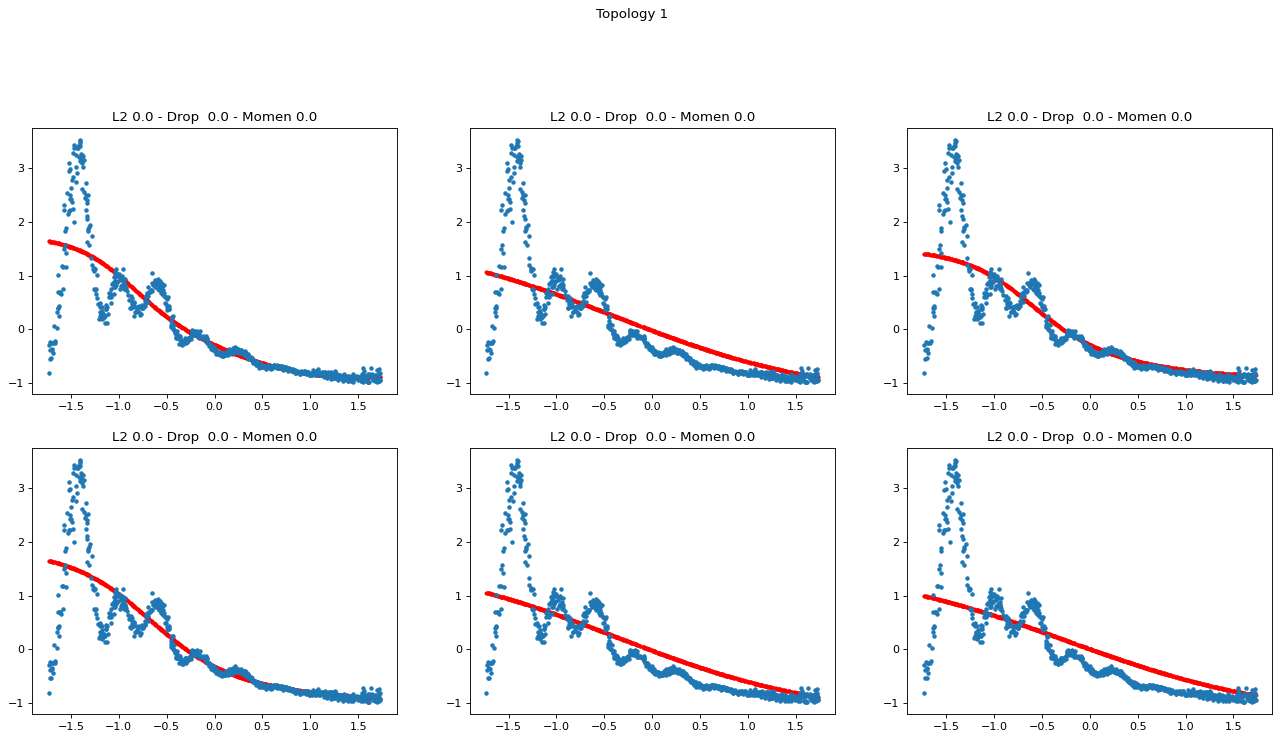

In [60]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 1')
for i in range(len( model_1)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_1[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 0.0 - Drop  0.0 - Momen 0.0')
#plt.xscale('log')

In [61]:
score_1 = []
for i in range(len(           model_1)): 
  score_1.append(             model_1[i].evaluate(x_test, y_test, verbose=0))
  print('Model_1'+str(i))
  print("Test loss:",   round(score_1[i][0],5))
  print("Test metric:", round(score_1[i][1],5),'\n')


Model_10
Test loss: 0.289
Test metric: 0.27898 

Model_11
Test loss: 0.64245
Test metric: 0.37488 

Model_12
Test loss: 0.29048
Test metric: 0.28704 

Model_13
Test loss: 0.29133
Test metric: 0.28128 

Model_14
Test loss: 0.642
Test metric: 0.37437 

Model_15
Test loss: 0.64217
Test metric: 0.39602 



## Topology 2 

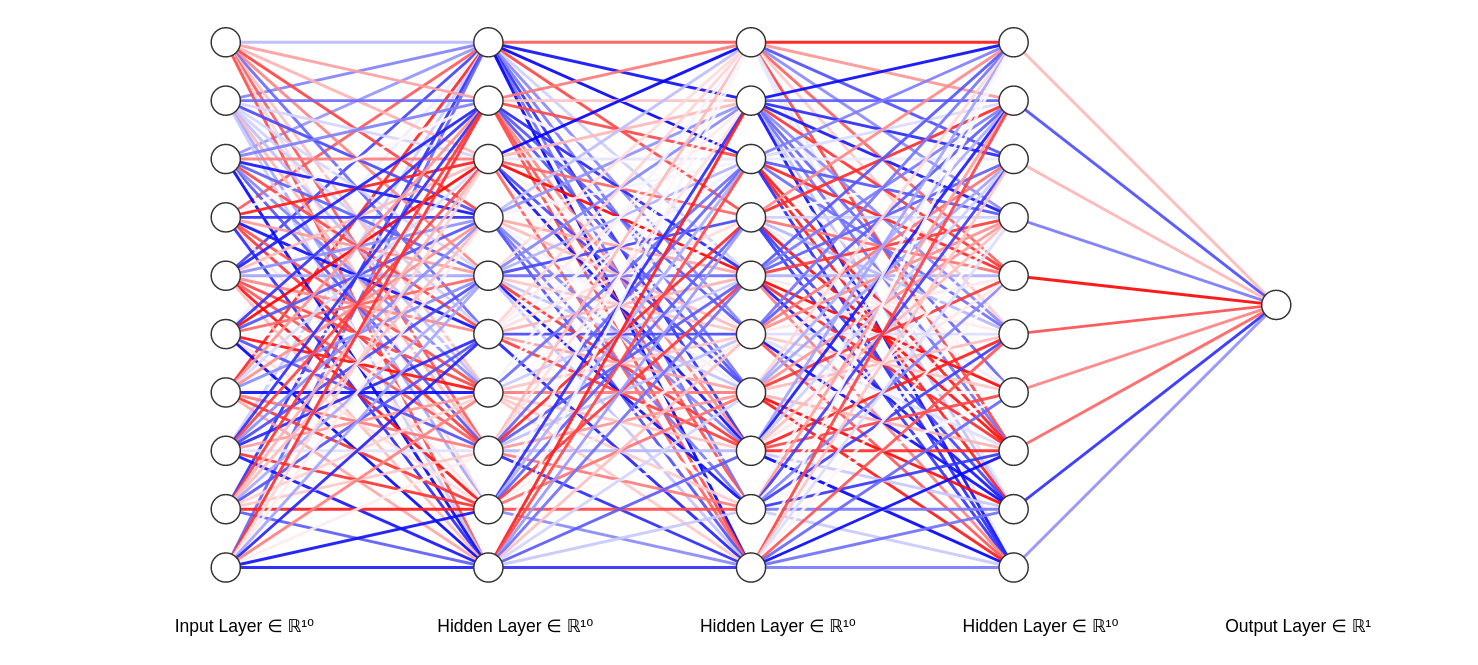

### Models for Topology 2


In [62]:
model_2 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_2.append(keras.Sequential())
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))
  model_2[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_2[i].add(Dropout(dropo[i]))  
  model_2[i].add(keras.layers.Dense(units=1, activation="linear"))
  model_2[i].compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])


### Treining Topology 2



In [63]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___2 = []
endti___2 = []
history_2 = []
for i in range(len(regul)):
  start___2.append(time.time())
  history_2.append(
    model_2[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___2.append(time.time())

A saída de streaming foi truncada nas últimas 5000 linhas.
61/61 [==============================] - 0s 5ms/step - loss: 0.0215 - mean_absolute_error: 0.0890 - val_loss: 0.0203 - val_mean_absolute_error: 0.0906
Epoch 502/1000
61/61 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0884 - val_loss: 0.0166 - val_mean_absolute_error: 0.0792
Epoch 503/1000
61/61 [==============================] - 0s 4ms/step - loss: 0.0212 - mean_absolute_error: 0.0862 - val_loss: 0.0172 - val_mean_absolute_error: 0.0845
Epoch 504/1000
61/61 [==============================] - 0s 5ms/step - loss: 0.0215 - mean_absolute_error: 0.0886 - val_loss: 0.0165 - val_mean_absolute_error: 0.0813
Epoch 505/1000
61/61 [==============================] - 0s 5ms/step - loss: 0.0213 - mean_absolute_error: 0.0879 - val_loss: 0.0182 - val_mean_absolute_error: 0.0864
Epoch 506/1000
61/61 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0863 - val_loss: 0

### Results Topology 2


In [64]:
#Time Running Out
for i in range(len(start___2)):
  print(round((    endti___2[i]- start___2[i])/60,5),'minuts')
print(round((      endti___2[-1]-start___2[0])/60,5),'minuts TOTAL')

4.38032 minuts
5.376 minuts
5.37786 minuts
5.38029 minuts
5.38044 minuts
5.3829 minuts
31.27781 minuts TOTAL


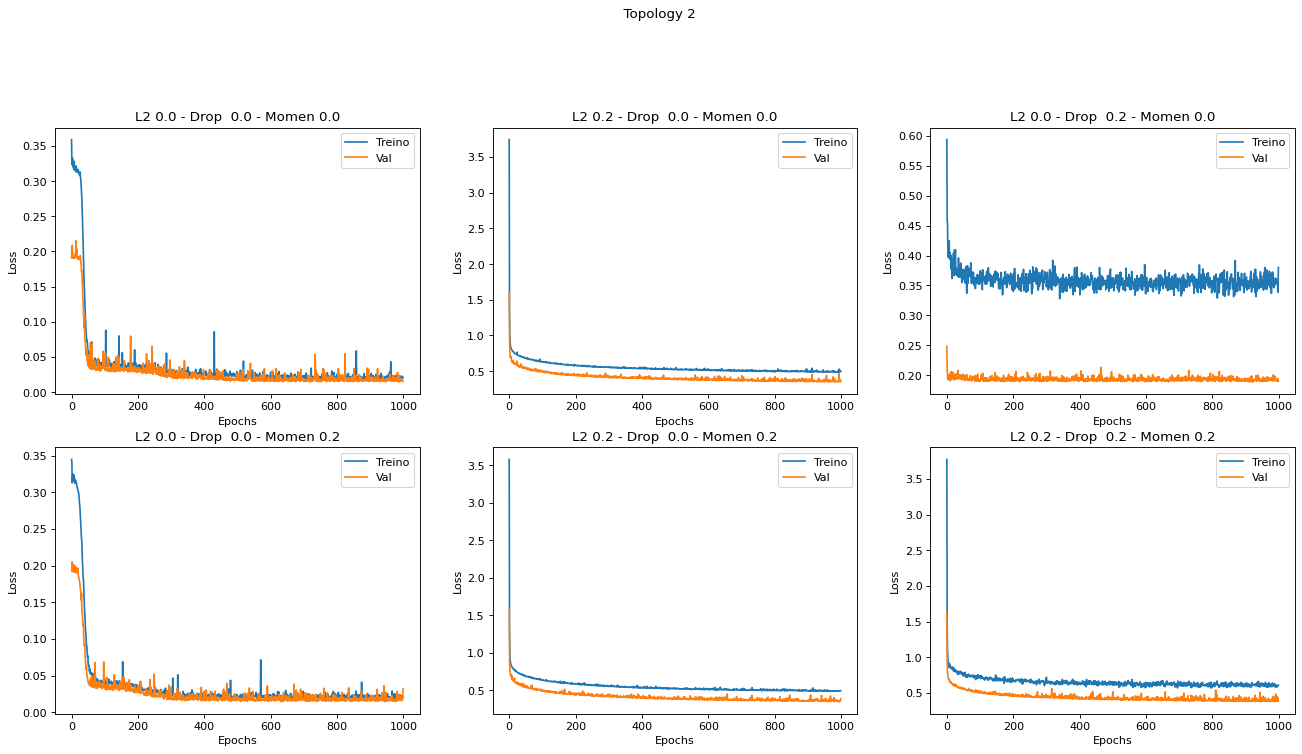

In [65]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("  Topology 2")
for i in range(len(model_2)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(      history_2[i].history['loss'], label="Treino")
  plt.plot(      history_2[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.legend()

### Avaliation Topology 2

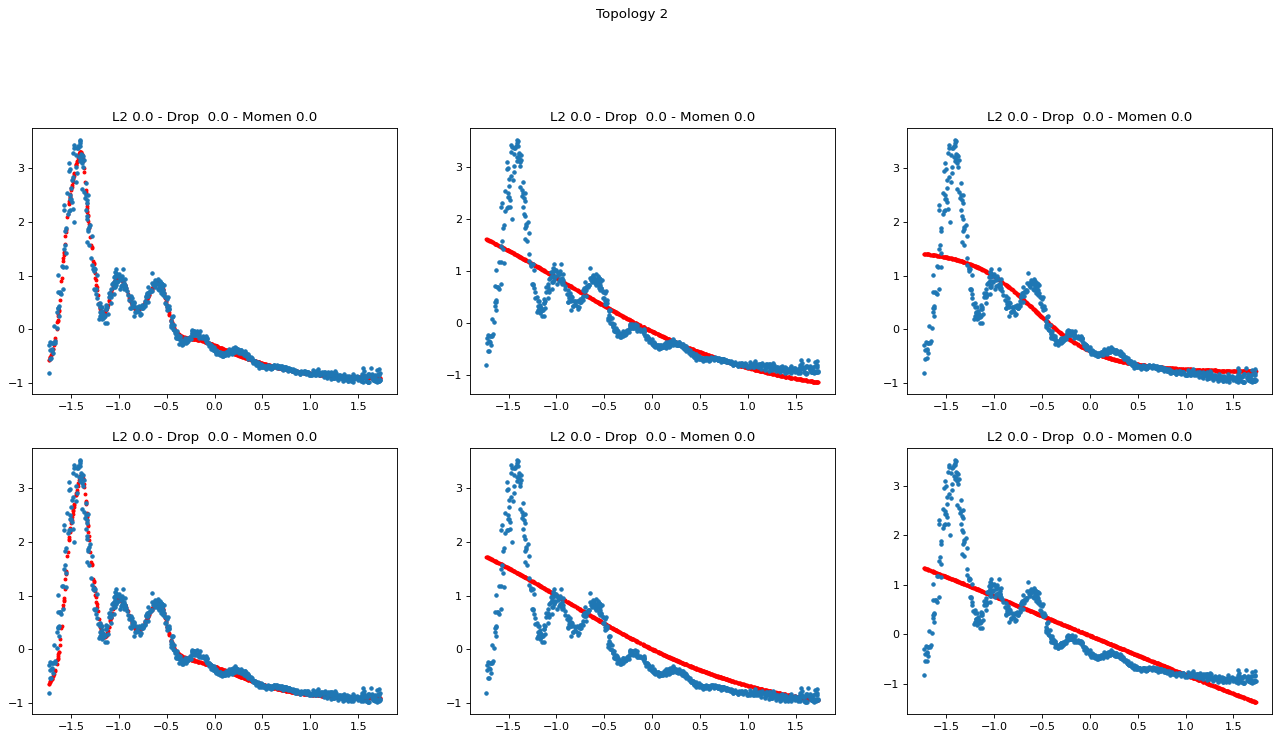

In [66]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 2')
for i in range(len( model_2)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_2[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
#plt.xscale('log')

In [67]:
score_2 = []
for i in range(len(           model_2)): 
  score_2.append(             model_2[i].evaluate(x_test, y_test, verbose=0))
  print(                     'Model_2'+str(i))
  print("Test loss:",   round(score_2[i][0],5))
  print("Test metric:", round(score_2[i][1],5),'\n')

Model_20
Test loss: 0.02338
Test metric: 0.08783 

Model_21
Test loss: 0.4544
Test metric: 0.31004 

Model_22
Test loss: 0.29293
Test metric: 0.29956 

Model_23
Test loss: 0.03994
Test metric: 0.10998 

Model_24
Test loss: 0.47597
Test metric: 0.36813 

Model_25
Test loss: 0.4838
Test metric: 0.36661 



## Topology 3

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top3.png?raw=true">

### Models for Topology 3

In [68]:
model_3 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_3.append(keras.Sequential())
  model_3[i].add(keras.layers.Dense(units=50,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=40,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=30,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=20,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=10,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_3[i].add(Dropout(dropo[i]))
  model_3[i].add(keras.layers.Dense(units=1, activation="linear"))
  model_3[i].compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])


### Training Topology 3

In [69]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___3 = []
endti___3 = []
history_3 = []
for i in range(len(regul)):
  start___3.append(time.time())
  history_3.append(model_3[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___3.append(time.time())

A saída de streaming foi truncada nas últimas 5000 linhas.
61/61 [==============================] - 1s 9ms/step - loss: 0.0255 - mean_absolute_error: 0.0993 - val_loss: 0.0160 - val_mean_absolute_error: 0.0866
Epoch 502/1000
61/61 [==============================] - 1s 9ms/step - loss: 0.0214 - mean_absolute_error: 0.0878 - val_loss: 0.0162 - val_mean_absolute_error: 0.0822
Epoch 503/1000
61/61 [==============================] - 0s 8ms/step - loss: 0.0212 - mean_absolute_error: 0.0872 - val_loss: 0.0361 - val_mean_absolute_error: 0.1034
Epoch 504/1000
61/61 [==============================] - 0s 8ms/step - loss: 0.0220 - mean_absolute_error: 0.0902 - val_loss: 0.0203 - val_mean_absolute_error: 0.0891
Epoch 505/1000
61/61 [==============================] - 0s 7ms/step - loss: 0.0204 - mean_absolute_error: 0.0846 - val_loss: 0.0165 - val_mean_absolute_error: 0.0820
Epoch 506/1000
61/61 [==============================] - 0s 7ms/step - loss: 0.0222 - mean_absolute_error: 0.0892 - val_loss: 0

### Results Topology 3

In [70]:
#Time Running Out
for i in range(len(start___3)):
  print(round((    endti___3[i]- start___3[i])/60,5),'minuts')
print(round((      endti___3[-1]-start___3[0])/60,5),'minuts TOTAL')

5.38158 minuts
5.38322 minuts
5.74585 minuts
6.38188 minuts
7.38322 minuts
7.38925 minuts
37.66501 minuts TOTAL


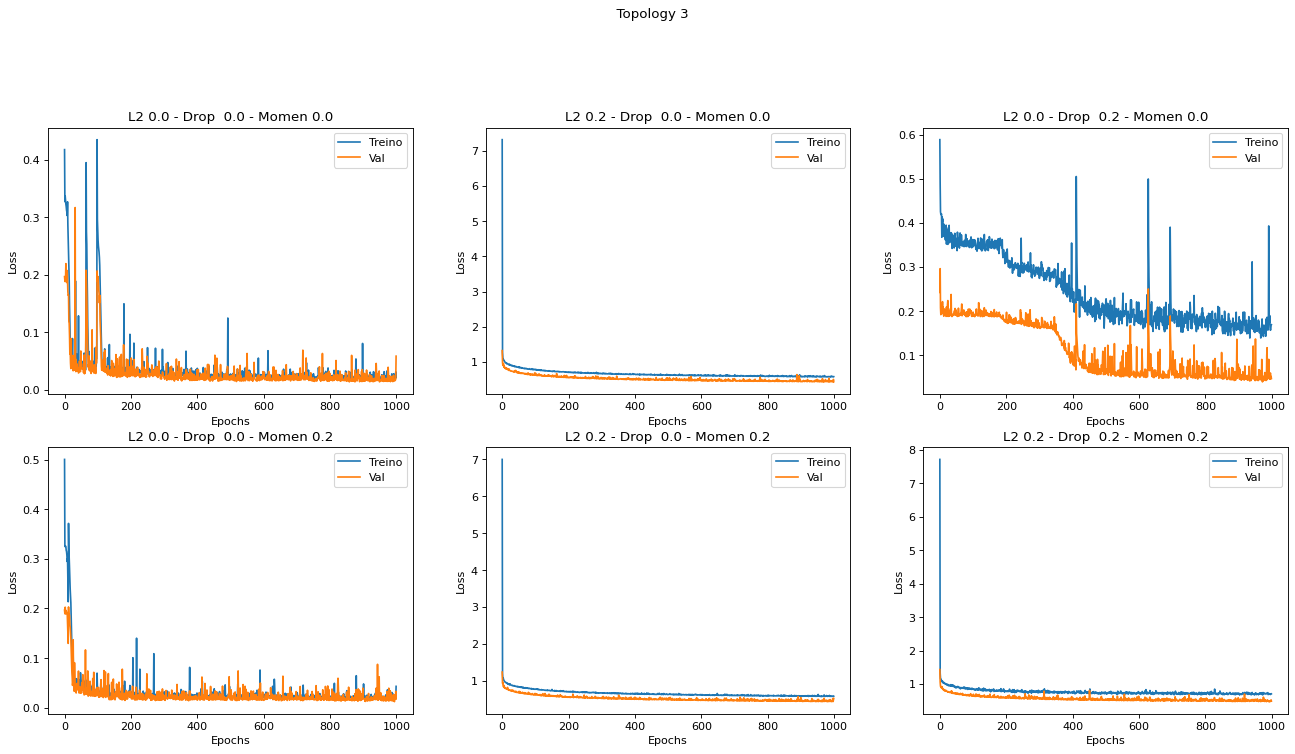

In [71]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("  Topology 3")
for i in range(len(model_3)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(      history_3[i].history['loss'], label="Treino")
  plt.plot(      history_3[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.legend()

### Avaliation Topology 3 



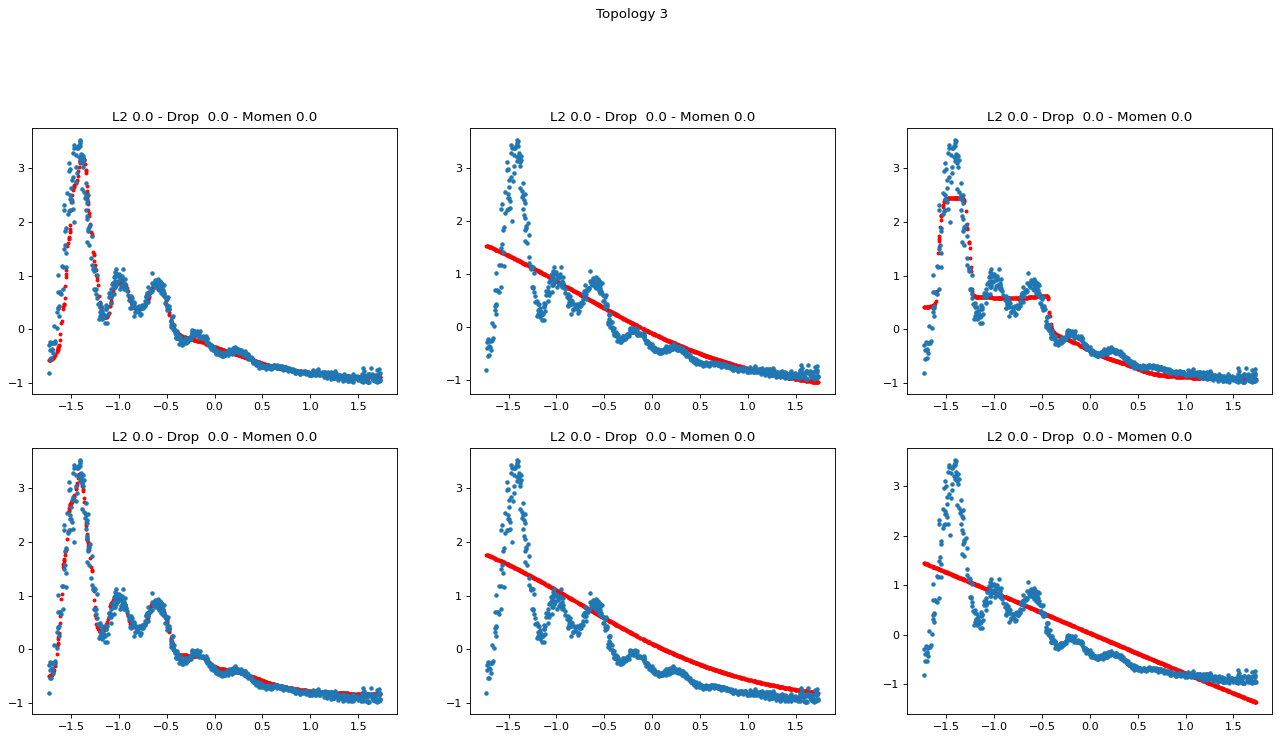

In [72]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 3')
for i in range(len( model_3)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_3[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
#plt.xscale('log')

In [73]:
score_3 = []
for i in range(len(           model_3)): 
  score_3.append(             model_3[i].evaluate(x_test, y_test, verbose=0))
  print(                     'Model_3'+str(i))
  print("Test loss:",   round(score_3[i][0],5))
  print("Test metric:", round(score_3[i][1],5),'\n')

Model_30
Test loss: 0.06239
Test metric: 0.12754 

Model_31
Test loss: 0.53802
Test metric: 0.30947 

Model_32
Test loss: 0.07017
Test metric: 0.17128 

Model_33
Test loss: 0.02594
Test metric: 0.09672 

Model_34
Test loss: 0.60047
Test metric: 0.44286 

Model_35
Test loss: 0.58468
Test metric: 0.38394 



## Topology 4 

### Models for Topology 4

<img src="https://github.com/barauna-lo/Neurocomputing/blob/main/figures/top4.png?raw=true">

In [74]:
#Model_4 
model_4 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_4.append(keras.Sequential())
  model_4[i].add(keras.layers.Dense(units=100,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=100,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_4[i].add(Dropout(dropo[i]))
  model_4[i].add(keras.layers.Dense(units=50,kernel_regularizer=l2(regul[i]), activation="sigmoid"))
  model_4[i].add(keras.layers.Dense(units=1, activation="linear"))
  model_4[i].compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])


### Traing Topology 4

In [75]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___4 = []
endti___4 = []
history_4 = []
for i in range(len(regul)):
  start___4.append(time.time())
  history_4.append(
    model_4[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___4.append(time.time())

A saída de streaming foi truncada nas últimas 5000 linhas.
61/61 [==============================] - 1s 9ms/step - loss: 0.0675 - mean_absolute_error: 0.1430 - val_loss: 0.0282 - val_mean_absolute_error: 0.1224
Epoch 502/1000
61/61 [==============================] - 1s 9ms/step - loss: 0.0305 - mean_absolute_error: 0.1011 - val_loss: 0.0472 - val_mean_absolute_error: 0.1193
Epoch 503/1000
61/61 [==============================] - 1s 10ms/step - loss: 0.0253 - mean_absolute_error: 0.0979 - val_loss: 0.0268 - val_mean_absolute_error: 0.0959
Epoch 504/1000
61/61 [==============================] - 1s 10ms/step - loss: 0.0255 - mean_absolute_error: 0.0978 - val_loss: 0.0150 - val_mean_absolute_error: 0.0725
Epoch 505/1000
61/61 [==============================] - 1s 9ms/step - loss: 0.0248 - mean_absolute_error: 0.0976 - val_loss: 0.0217 - val_mean_absolute_error: 0.1007
Epoch 506/1000
61/61 [==============================] - 1s 10ms/step - loss: 0.0301 - mean_absolute_error: 0.1040 - val_loss

### Results Topology 4

In [76]:
#Time Running Out
for i in range(len(start___4)):
  print(round((    endti___4[i]- start___4[i])/60,5),'minuts')
print(round((      endti___4[-1]-start___4[0])/60,5),'minuts TOTAL')

10.3881 minuts
9.39586 minuts
9.34131 minuts
9.444 minuts
9.38487 minuts
8.38698 minuts
56.34111 minuts TOTAL


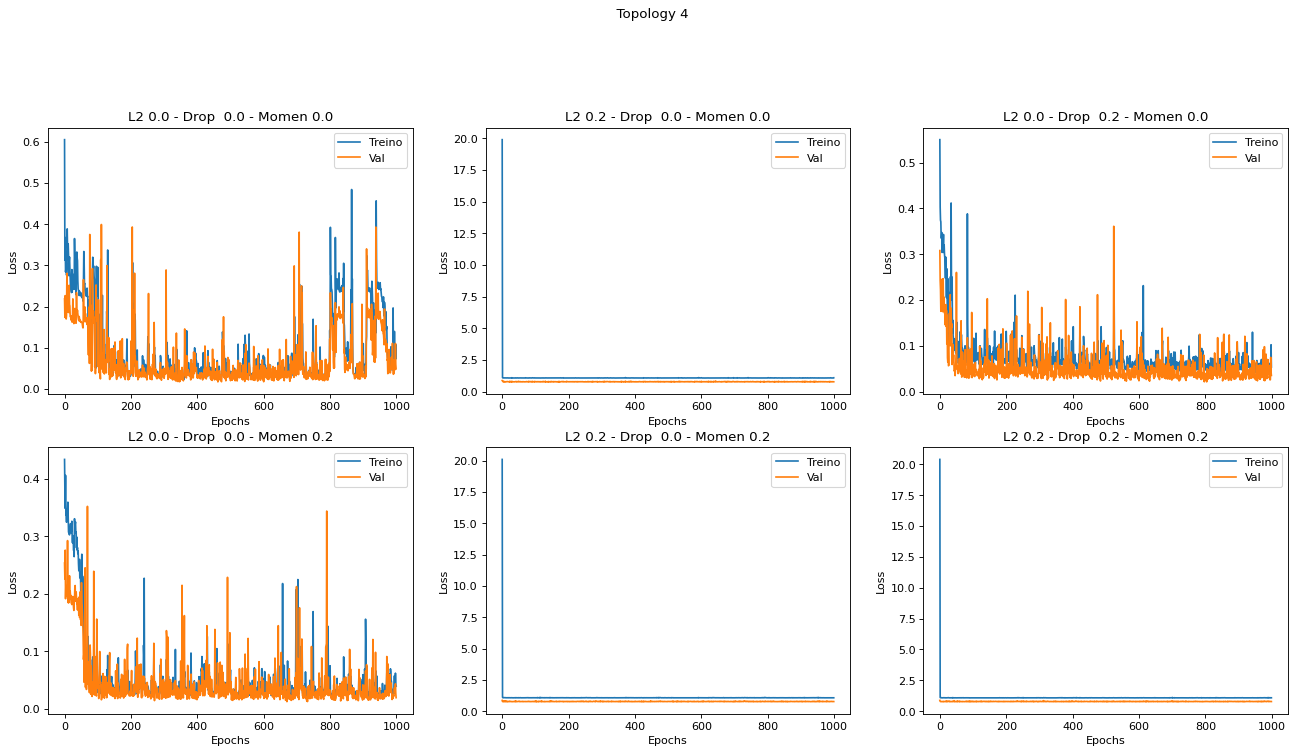

In [77]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("  Topology 4")
for i in range(len(model_4)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(      history_4[i].history['loss'], label="Treino")
  plt.plot(      history_4[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.legend()

### Avaliation for Topology 4

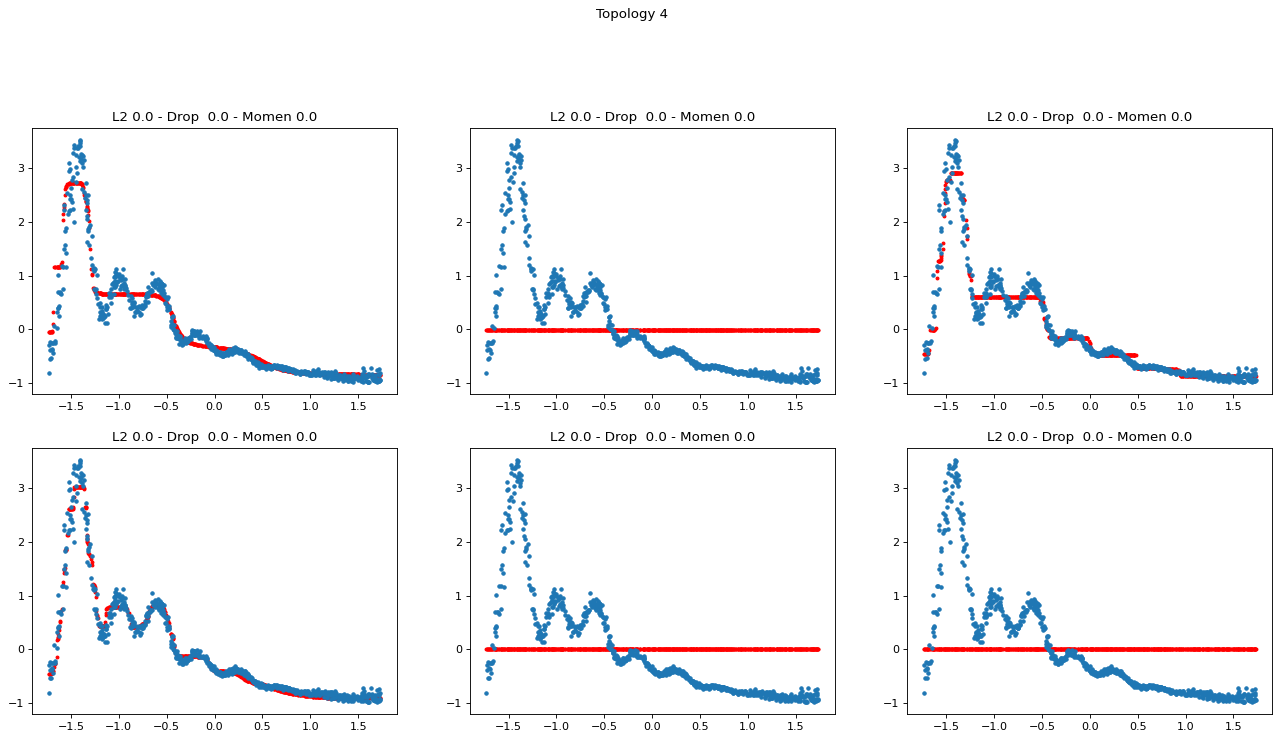

In [78]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 4')
for i in range(len( model_4)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_4[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
#plt.xscale('log')

In [79]:
score_4 = []
for i in range(len(           model_4)): 
  score_4.append(             model_4[i].evaluate(x_test, y_test, verbose=0))
  print(                     'Model_4'+str(i))
  print("Test loss:",   round(score_4[i][0],5))
  print("Test metric:", round(score_4[i][1],5),'\n')

Model_40
Test loss: 0.07163
Test metric: 0.15751 

Model_41
Test loss: 0.99545
Test metric: 0.76393 

Model_42
Test loss: 0.04426
Test metric: 0.12983 

Model_43
Test loss: 0.02848
Test metric: 0.101 

Model_44
Test loss: 0.99214
Test metric: 0.76889 

Model_45
Test loss: 0.99308
Test metric: 0.76828 



## Topology 5 

### Models for Topology 5

In [80]:
#Model_5 
model_5 = []
regul = [0.0,0.2,0.0,0.0,0.2,0.2]
dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
moment= [0.0,0.0,0.0,0.2,0.2,0.2]

for i in range(len(regul)):
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
  model_5.append(keras.Sequential())
  model_5[i].add(keras.layers.Dense(units=100,kernel_regularizer=l2(regul[i]), input_shape=[1], activation="tanh"))
  model_5[i].add(Dropout(dropo[i]))
  model_5[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="sigmoid"))
  model_5[i].add(Dropout(dropo[i]))
  model_5[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_5[i].add(Dropout(dropo[i]))
  model_5[i].add(keras.layers.Dense(units=200,kernel_regularizer=l2(regul[i]), activation="sigmoid"))
  model_5[i].add(Dropout(dropo[i]))
  model_5[i].add(keras.layers.Dense(units=100,kernel_regularizer=l2(regul[i]), activation="tanh"))
  model_5[i].add(Dropout(dropo[i]))
  model_5[i].add(keras.layers.Dense(units=50,kernel_regularizer=l2(regul[i]), activation="sigmoid"))
  model_5[i].add(keras.layers.Dense(units=1, activation="relu"))
  model_5[i].compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])


### Traing Topology 5

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
ages = 1000
#Traing Model_11
start___5 = []
endti___5 = []
history_5 = []
for i in range(len(regul)):
  start___5.append(time.time())
  history_5.append(
    model_5[i].fit(x_train, y_train, epochs=ages, batch_size=10, validation_split=0.2, verbose=1))#, 
  endti___5.append(time.time())

Epoch 1/1000
61/61 [==============================] - 2s 12ms/step - loss: 1.0732 - mean_absolute_error: 0.7968 - val_loss: 0.7801 - val_mean_absolute_error: 0.7112
Epoch 2/1000
61/61 [==============================] - 0s 8ms/step - loss: 1.0768 - mean_absolute_error: 0.7968 - val_loss: 0.7801 - val_mean_absolute_error: 0.7112
Epoch 3/1000
61/61 [==============================] - 0s 8ms/step - loss: 1.0768 - mean_absolute_error: 0.7968 - val_loss: 0.7801 - val_mean_absolute_error: 0.7112
Epoch 4/1000
61/61 [==============================] - 0s 7ms/step - loss: 1.0768 - mean_absolute_error: 0.7968 - val_loss: 0.7801 - val_mean_absolute_error: 0.7112
Epoch 5/1000
61/61 [==============================] - 1s 8ms/step - loss: 1.0768 - mean_absolute_error: 0.7968 - val_loss: 0.7801 - val_mean_absolute_error: 0.7112
Epoch 6/1000
61/61 [==============================] - 0s 8ms/step - loss: 1.0768 - mean_absolute_error: 0.7968 - val_loss: 0.7801 - val_mean_absolute_error: 0.7112
Epoch 7/1000
61

### Results Topology 5

In [ ]:
#Time Running Out
for i in range(len(start___5)):
  print(round((    endti___5[i]- start___4[i])/60,5),'minuts')
print(round((      endti___5[-1]-start___4[0])/60,5),'minuts TOTAL')

In [ ]:
figure(figsize=(20,15),dpi=80)
plt.suptitle("  Topology 5")
for i in range(len(model_5)):
  plt.subplot(3,3,(i+1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(      history_5[i].history['loss'], label="Treino")
  plt.plot(      history_5[i].history['val_loss'], label="Val")
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
  plt.legend()

### Avaliation for Topology 5

In [ ]:
figure(figsize=(20,15),dpi=80)
plt.suptitle(   'Topology 5')
for i in range(len( model_5)):
  plt.subplot(3,3,(i+1))
  plt.plot(x_train, model_5[i].predict(x_train), '.', markersize=5 ,color='red')
  plt.plot(x_train, y_train, '.', color='C0')
  plt.title('L2 '+str(regul[i])+' - Drop  '+str(dropo[i])+' - Momen '+str(moment[i])+'')
#plt.xscale('log')

In [ ]:
score_4 = []
for i in range(len(           model_5)): 
  score_5.append(             model_5[i].evaluate(x_test, y_test, verbose=0))
  print(                     'Model_5'+str(i))
  print("Test loss:",   round(score_5[i][0],5))
  print("Test metric:", round(score_5[i][1],5),'\n')

# References

[HAYKIN, Simon. Redes Neurais: Princípios e prática. Porto Alegre
RS:Bookman, 2001.](https://www.amazon.com.br/Redes-Neurais-Princ%C3%ADpios-Simon-Haykin-ebook/dp/B073QSG69Y)

http://alexlenail.me/NN-SVG/index.html

https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d

https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8